In [1]:
import os
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view as sliding_window
from PIL import Image
from natsort import natsorted

# Neuron Segmentation on 2pFLIM

### Sangwook Suh 455105

In [41]:
PATH = './data/'
EASY = './data/easy/'
MEDIUM = './data/medium/'
HARD = './data/hard/'
TRUTH = 'ground truth/'
INTENSITY = 'intensities/'
LIFETIME = 'lifetimes/'
PNG = '*.png'
EXAMPLE = PATH+EASY+INTENSITY+'intensities_ycAKAR413_C1_1.png'

In [3]:
def load_video(path):
    # Rows 40-199 have images!
    # Columns 114-273 has image!
    # Index by [40:200, 114:274]!
    
    return np.array([
        np.asarray(Image.open(path+file))[40:200,114:274] \
         for file in natsorted(os.listdir(path)) \
         if file.endswith('.png')
    ])

In [4]:
easy_intensity = load_video(PATH+EASY+INTENSITY)
easy_intensity.shape

(38, 160, 160, 3)

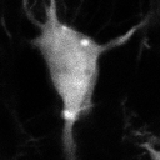

In [5]:
Image.fromarray(easy_intensity[10])

In [6]:
easy_intensity[10][80][80]

array([187, 187, 187], dtype=uint8)

In [8]:
easy_lifetime = load_video(PATH+EASY+LIFETIME)
easy_lifetime.shape 

(38, 160, 160, 3)

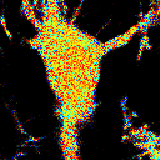

In [9]:
Image.fromarray(easy_lifetime[10])

In [10]:
easy_truth = load_video(PATH+EASY+TRUTH)
easy_truth[10][80][80]

array([255, 255, 255], dtype=uint8)

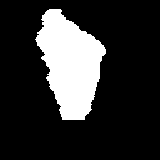

In [11]:
Image.fromarray(easy_truth[10])

In [12]:
def imageToGrayscale(image):
    return np.array([[sum(cell)/3 for cell in row] for row in image])

def imageToRed(image):
    return np.array([[cell[0] for cell in row] for row in image])

def imageToGreen(image):
    return np.array([[cell[1] for cell in row] for row in image])

def imageToBlue(image):
    return np.array([[cell[2] for cell in row] for row in image])

def grayscaleToImage(grayscale):
    return np.array([[[cell, cell, cell] for cell in row] for row in grayscale], dtype=np.uint8)

In [13]:
imageToGrayscale(easy_intensity[10])

array([[  9.,   6.,   9., ...,  17.,  17.,  14.],
       [  6.,   8.,  10., ...,  18.,  18.,  18.],
       [ 10.,   8.,   9., ...,  16.,  16.,  18.],
       ...,
       [  6.,   9.,   7., ..., 109., 109., 113.],
       [  6.,   9.,   7., ..., 109., 109., 113.],
       [  9.,   9.,   7., ...,  97.,  97., 117.]])

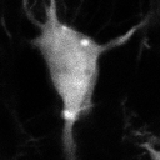

In [14]:
Image.fromarray(grayscaleToImage(imageToGrayscale(easy_intensity[10])))

In [15]:
def threshold(image, value):
    return image >= value

def binaryToImage(binary):
    return np.array([[[pixel*255, pixel*255, pixel*255] for pixel in row] for row in binary], dtype=np.uint8)

def binaryIntersection(img1, img2):
    return img1 & img2

def binaryUnion(img1, img2):
    return img1 | img2

def binaryIOU(img1, img2):
    return np.sum(img1 & img2)/np.sum(img1 | img2)

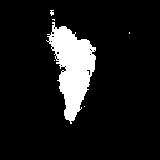

In [16]:
img1gray = imageToGrayscale(easy_intensity[10])
img1 = threshold(img1gray,128)
Image.fromarray(binaryToImage(img1))

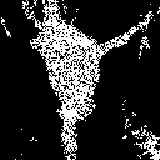

In [17]:
img2gray = imageToGrayscale(easy_lifetime[10])
img2red = imageToRed(easy_lifetime[10])
img2green = imageToGreen(easy_lifetime[10])
img2blue = imageToBlue(easy_lifetime[10])
img2 = threshold(img2gray,128)
Image.fromarray(binaryToImage(img2))

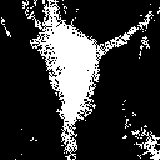

In [18]:
Image.fromarray(binaryToImage(binaryUnion(img1, img2)))

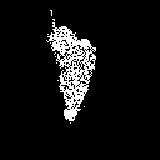

In [19]:
Image.fromarray(binaryToImage(binaryIntersection(img1, img2)))

In [20]:
binaryIOU(img1, img2)

0.35540390999631133

In [21]:
def showGrayscaleImage(gray_image):
    display(Image.fromarray(grayscaleToImage(gray_image)))


def showBinaryImage(binary_image):
    display(Image.fromarray(binaryToImage(binary_image)))

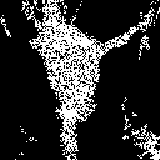

None

In [22]:
display(showBinaryImage(threshold(img2green,128)))

In [16]:
def invertBinaryImage(bin_image):
    return 1 - bin_image

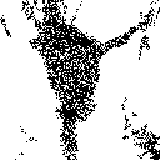

In [24]:
showBinaryImage(invertBinaryImage(threshold(img2green, 128)))

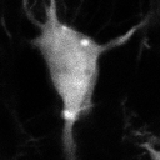

In [25]:
showGrayscaleImage(imageToGrayscale(easy_intensity[10]))

In [26]:
img2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False]])

In [27]:
img2[158, 158]

True

In [28]:
img2.shape

(160, 160)

In [13]:
ex = np.array([
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0]
])
ex

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [32]:
ey = np.array([
    [0,1,1,1,0],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1]
])

# Morphological Operators!

In [22]:
def erode(img, n=1):
    
    for _ in range(n):
        img = np.prod(np.prod(sliding_window(np.pad(img, 1), (3,3)),axis=2),axis=2)
        
    return img


def dilate(img, n=1):
     
    return invertBinaryImage(erode(invertBinaryImage(img)))


def opening(img, n=1):

    return dilate(erode(img, n), n)


def closing(img, n=1):
    
    return invertBinaryImage(opening(invertBinaryImage(img), n))

In [18]:
def erode(img):
    
    return np.prod(np.prod(sliding_window(np.pad(img, 1), (3,3)),axis=2),axis=2)


def dilate(img):
     
    return invertBinaryImage(erode(invertBinaryImage(img)))


def opening(img, n=1):
    
    for _ in range(n):
        img = erode(img)
    for _ in range(n):
        img = dilate(img)

    return img


def closing(img, n=1):
    
    return invertBinaryImage(opening(invertBinaryImage(img)))

In [27]:
showBinaryImage(img1)

NameError: name 'showBinaryImage' is not defined

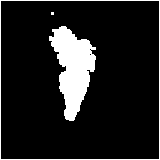

In [34]:
showBinaryImage(dilate(erode(img1)))

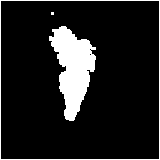

In [35]:
showBinaryImage(opening(img1))

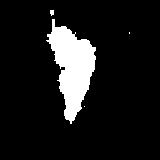

In [36]:
showBinaryImage(erode(dilate(img1)))

In [30]:
opening(ex)

array([[1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [34]:
erode(ey)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [37]:
invertBinaryImage(dilate(invertBinaryImage(ey)))

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [40]:
erode(invertBinaryImage(ex))

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

# Connectivity!

In [37]:
def locInBounds(loc, dims):
    return all([0<=loc[0], loc[0]<dims[0], 0<=loc[1], loc[1]<dims[1]])


def flood(img, mask, flags, loc, dims):
        
    if locInBounds(loc, dims):
    
        if img[loc] and not flags[loc]:
            
            mask[loc] = True
            flags[loc] = True
            i, j = loc
            
            flood(img, mask, flags, (i+1, j), dims)
            flood(img, mask, flags, (i-1, j), dims)
            flood(img, mask, flags, (i, j+1), dims)
            flood(img, mask, flags, (i, j-1), dims)
            
    return mask

In [39]:
def labelCC(img):
    # Get n largest 4-connected components of a binary image as a binary mask
    
    dims = img.shape
    flags = np.full(dims, False)
    comps = np.zeros(dims)
    label = 0
    
    # For each pixel
    for i in range(dims[0]):
        for j in range(dims[1]):
            
            # If pixel is object and not labeled yet
            if img[i, j] and not comps[i, j]: 
                
                # Flood pixel and label the flooded component
                label += 1
                comps += label * flood(img, np.full(dims, False), flags, (i,j), dims)
                
    return comps

In [40]:
def nLargestCC(img, n=1):
    
    comps = labelCC(img)
        
    labels, counts = np.unique(comps, return_counts = True)
    largest = labels[1:][np.argsort(counts[1:])[::-1][:n]]    

    return np.logical_or.reduce([comps == part for part in largest])

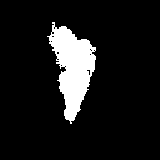

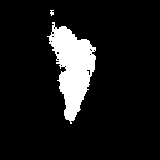

In [41]:
showBinaryImage(nLargestCC(img1, 1))
showBinaryImage(nLargestCC(img1, 2))

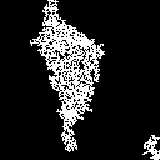

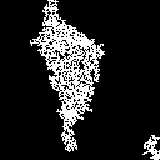

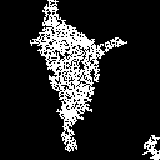

In [43]:
showBinaryImage(nLargestCC(img2, 2))
showBinaryImage(nLargestCC(img2, 2))
showBinaryImage(nLargestCC(img2, 3))

# Scaling!

In [44]:
easy_inten = [ imageToGrayscale(img) for img in easy_intensity ]

In [45]:
easy_inten[0].shape

(160, 160)

In [47]:
easy_gray = [imageToGrayscale(img) for img in easy_lifetime]
easy_red = [ imageToRed(img) for img in easy_lifetime ]
easy_green = [ imageToGreen(img) for img in easy_lifetime ]
easy_blue = [ imageToBlue(img) for img in easy_lifetime ]

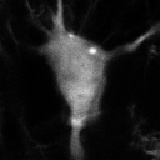

In [49]:
showGrayscaleImage(easy_inten[0])

In [57]:
def normalize(img):
    return StandardScaler().fit_transform(img.reshape(-1,1)).reshape(img.shape)

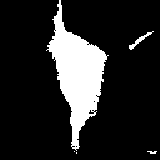

In [65]:
showBinaryImage(normalize(easy_inten[0]) >= 1)

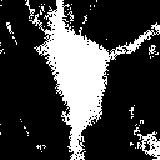

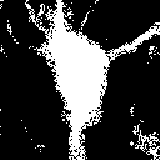

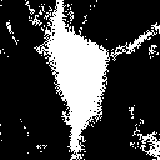

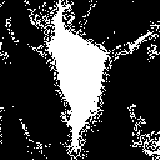

In [80]:
showBinaryImage((normalize(easy_gray[0]) >= 1) | (normalize(easy_inten[0])>=1))
showBinaryImage((normalize(easy_red[0]) >= 1) | (normalize(easy_inten[0])>=1))
showBinaryImage((normalize(easy_green[0]) >= 1) | (normalize(easy_inten[0])>=1))
showBinaryImage((normalize(easy_blue[0]) >= 1) | (normalize(easy_inten[0])>=1))

In [81]:
a = (normalize(easy_gray[0]) >= 1) | (normalize(easy_inten[0])>=1)
b = (normalize(easy_red[0]) >= 1) | (normalize(easy_inten[0])>=1)
c = (normalize(easy_green[0]) >= 1) | (normalize(easy_inten[0])>=1)
d = (normalize(easy_blue[0]) >= 1) | (normalize(easy_inten[0])>=1)

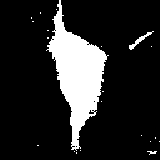

In [82]:
showBinaryImage(a & b & c & d)

In [93]:
easy_truth = load_video(PATH+EASY+TRUTH)
easy_truth = [imageToGrayscale(img).astype(bool) for img in easy_truth]

easy_truth[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [94]:
easy_truth[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Solving Problem!

In [42]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)


def load_data(path, threshold):
    
    print('Loading data...')
    
    truth = [imageToGrayscale(img).astype(bool) for img in load_video(path+'ground truth/')]
    print('\tTruth data loaded!')
    
    intensity = [normalize(imageToGrayscale(img)) >= threshold 
                 for img in load_video(path + 'intensities/')]
    print('\tIntensity data loaded!')
    
    lifetime = load_video(path + 'lifetimes/')
    gray = [normalize(imageToGrayscale(img)) >= threshold for img in lifetime]
    red = [normalize(imageToRed(img)) >= threshold for img in lifetime]
    green = [normalize(imageToGreen(img)) >= threshold for img in lifetime]
    blue = [normalize(imageToBlue(img)) >= threshold for img in lifetime]
    print('\tLifetime data loaded!')
    print('All data loaded!')
    
    return intensity, gray, red, green, blue, truth

    
def getIOU(solution, truth):
    return np.sum(solution & truth)/np.sum(solution | truth)


def save_video(path, video):
    
    print('Saving solution ..')
    
    i = 0
    save_path = path+'solutions/'
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    for frame in video:
        i += 1
        Image.fromarray(frame).save(save_path+str(i)+'.png')
        
    print('Solution saved at '+save_path)

In [151]:
def processFrame(intensity, gray, red, green, blue):
    
    return intensity

In [43]:
def solve(path, num_cc=1, threshold=1):
    
    intensities, grays, reds, greens, blues, truths = load_data(path, threshold)
    
    solutions = []
    scores = []
    i = 0
    
    print('')
    print('Starting solve:')
    for intensity, gray, red, green, blue, truth in zip(intensities, grays, reds, greens, blues, truths):
        
        i+=1
        solutions.append(solution := processFrame(intensity, gray, red, green, blue))
        scores.append(score := getIOU(solution, truth))
        
        if i%5==0:
            print('\tFrame {:2} processed with score {:0.3f}'.format(i, score))
        
    print('Solve finished with average accuracy {:0.3f}'.format(sum(scores)/len(scores)))
    
    print('')
    save_video(path, solutions)
    

In [149]:
%%time
solve('./data/ycAKAR413_C1/')

Loading data...
	Truth data loaded
	Intensity data loaded!
	Lifetime data loaded!
All data loaded!

Starting solve:
	Frame  5 processed with score 0.689
	Frame 10 processed with score 0.708
	Frame 15 processed with score 0.654
	Frame 20 processed with score 0.668
	Frame 25 processed with score 0.706
	Frame 30 processed with score 0.715
	Frame 35 processed with score 0.696
Solve finished with average accuracy 0.684

Saving solution ..
Solution saved at ./data/ycAKAR413_C1/solutions/
CPU times: user 3.73 s, sys: 23.9 ms, total: 3.75 s
Wall time: 3.78 s


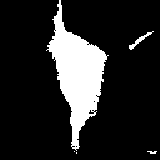

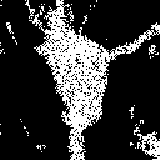

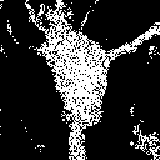

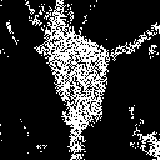

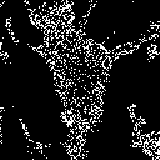

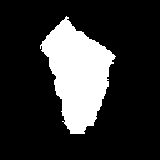

In [116]:
showBinaryImage(intensity[0])
showBinaryImage(gray[0])
showBinaryImage(red[0])
showBinaryImage(green[0])
showBinaryImage(blue[0])
showBinaryImage(truth[0])

In [2]:
arr = np.array([[True, False], [True, True]])

In [3]:
arr

array([[ True, False],
       [ True,  True]])

In [7]:
np.logical_not(arr)

array([[False,  True],
       [False, False]])

In [8]:
~arr

array([[False,  True],
       [False, False]])

In [9]:
arr

array([[ True, False],
       [ True,  True]])

In [10]:
~arr

array([[False,  True],
       [False, False]])

In [ ]:
def evaluate(path):
    
    